In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
df = pd.read_csv('imdb_top_1000.csv')

In [4]:
df_text = df[['Series_Title', 'Genre']]

In [5]:
sentences = df_text['Series_Title'].values
labels = df_text['Genre'].values

In [6]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [7]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['Genre'].unique()))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
train_tokenized = tokenizer(train_sentences.tolist(), padding=True, truncation=True, return_tensors='pt')
val_tokenized = tokenizer(val_sentences.tolist(), padding=True, truncation=True, return_tensors='pt')

In [10]:
train_dataset = TensorDataset(train_tokenized['input_ids'], train_tokenized['attention_mask'], torch.tensor(train_labels))
val_dataset = TensorDataset(val_tokenized['input_ids'], val_tokenized['attention_mask'], torch.tensor(val_labels))

In [11]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
total_steps = len(train_loader) * num_epochs

/Users/sivaprasanth/.pyenv/versions/3.10.12/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [15]:
losses = []
for epoch in range(num_epochs):
    model.train()

    for batch in train_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    losses.append(loss.detach().item())

    model.eval()

    total_correct = 0
    total_samples = 0

    for batch in val_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {accuracy}')

Epoch 1/3, Validation Accuracy: 0.055
Epoch 2/3, Validation Accuracy: 0.075
Epoch 3/3, Validation Accuracy: 0.075


Text(0, 0.5, 'Loss')

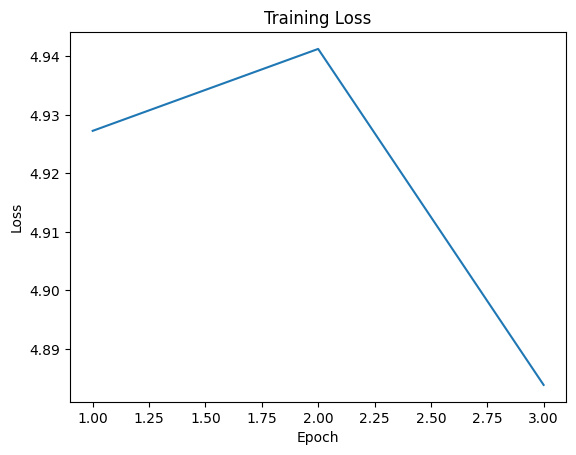

In [16]:
import matplotlib.pyplot as plt
plt.plot(range(1,num_epochs+1),losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')